# 10章 アンケート分析を行うための言語処理１０本ノック

ここでは、まちづくりのアンケートを使って分析していきます。  
主に言語処理を取り扱っていきます。
言語処理特有の処理や、データの持たせ方を学びましょう。

### ノック91：データを読み込んで把握しよう

In [198]:
import pandas as pd
survey = pd.read_csv("survey.csv")

In [199]:
print(len(survey))
survey.head()

86


,datetime,comment,satisfaction
0,2019/3/11,駅前に若者が集まっている(AA駅),1
1,2019/2/25,スポーツできる場所があるのが良い,5
2,2019/2/18,子育て支援が嬉しい,5
3,2019/4/9,保育園に入れる（待機児童なし）,4
4,2019/1/6,駅前商店街が寂しい,2


In [200]:
survey.isna().sum()

datetime        0
comment         2
satisfaction    0
dtype: int64

In [201]:
survey = survey.dropna()
survey.isna().sum()

datetime        0
comment         0
satisfaction    0
dtype: int64

### ノック92：不要な文字を除外してみよう

In [202]:
survey["comment"] = survey["comment"].str.replace("AA", "")
survey["comment"].head()

0     駅前に若者が集まっている(駅)
1    スポーツできる場所があるのが良い
2           子育て支援が嬉しい
3     保育園に入れる（待機児童なし）
4           駅前商店街が寂しい
Name: comment, dtype: object

In [203]:
survey["comment"] = survey["comment"].str.replace("\(.+?\)", "", regex=True)
survey.head()

,datetime,comment,satisfaction
0,2019/3/11,駅前に若者が集まっている,1
1,2019/2/25,スポーツできる場所があるのが良い,5
2,2019/2/18,子育て支援が嬉しい,5
3,2019/4/9,保育園に入れる（待機児童なし）,4
4,2019/1/6,駅前商店街が寂しい,2


In [204]:
survey["comment"] = survey["comment"].str.replace("\（.+?\）", "", regex=True)
survey.head()

,datetime,comment,satisfaction
0,2019/3/11,駅前に若者が集まっている,1
1,2019/2/25,スポーツできる場所があるのが良い,5
2,2019/2/18,子育て支援が嬉しい,5
3,2019/4/9,保育園に入れる,4
4,2019/1/6,駅前商店街が寂しい,2


### ノック93：文字数をカウントしてヒストグラムを表示してみよう

In [205]:
survey["length"] = survey["comment"].str.len()
survey.head()

,datetime,comment,satisfaction,length
0,2019/3/11,駅前に若者が集まっている,1,12
1,2019/2/25,スポーツできる場所があるのが良い,5,16
2,2019/2/18,子育て支援が嬉しい,5,9
3,2019/4/9,保育園に入れる,4,7
4,2019/1/6,駅前商店街が寂しい,2,9


(array([11., 24., 21., 10.,  6.,  6.,  5.,  0.,  0.,  1.]),
 array([ 4. ,  8.6, 13.2, 17.8, 22.4, 27. , 31.6, 36.2, 40.8, 45.4, 50. ]),
 <BarContainer object of 10 artists>)

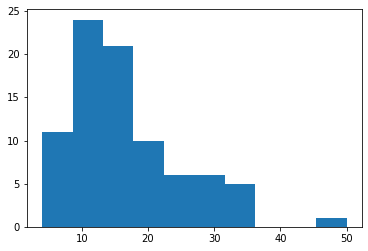

In [206]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(survey["length"])

### ノック94：形態素解析で文章を分割してみよう

In [207]:
import MeCab
tagger = MeCab.Tagger()
text = "すもももももももものうち"
words = tagger.parse(text)
words

'すもも\t名詞,一般,*,*,*,*,すもも,スモモ,スモモ\nも\t助詞,係助詞,*,*,*,*,も,モ,モ\nもも\t名詞,一般,*,*,*,*,もも,モモ,モモ\nも\t助詞,係助詞,*,*,*,*,も,モ,モ\nもも\t名詞,一般,*,*,*,*,もも,モモ,モモ\nの\t助詞,連体化,*,*,*,*,の,ノ,ノ\nうち\t名詞,非自立,副詞可能,*,*,*,うち,ウチ,ウチ\nEOS\n'

In [208]:
words = tagger.parse(text).splitlines()
words_arr = []
for i in words:
    if i == 'EOS': continue
    word_tmp = i.split()[0]
    words_arr.append(word_tmp)
words_arr

['すもも', 'も', 'もも', 'も', 'もも', 'の', 'うち']

### ノック95：形態素解析で文章から「動詞・名詞」を抽出してみよう

In [209]:
text = 'すもももももももものうち'
words = tagger.parse(text).splitlines()
words_arr = []
parts = ['名詞', '動詞']
for i in words:
    if i == 'EOS' or i == '': continue
    word_tmp = i.split()[0]
    part = i.split()[1].split(',')[0]
    if not (part in parts): continue
    words_arr.append(word_tmp)
words_arr

['すもも', 'もも', 'もも', 'うち']

### ノック96：形態素解析で抽出した頻出する名詞を確認してみよう

In [215]:
all_words = []
for n in range(len(survey)):
    text = survey['comment'].iloc[n]
    words = tagger.parse(text).splitlines()
    words_arr = []
    for w in words:
        if w == 'EOS' or w == '': continue
        category = w.split()[1].split(',')[0]
        if category == '名詞':
            word = w.split()[0]
            all_words.append(word)
all_words[:10]

['駅前', '若者', 'スポーツ', '場所', 'の', '子育て', '支援', '保育園', '駅前', '商店']

In [211]:
all_words_df = pd.DataFrame({'words': all_words, 'count': len(all_words)*[1]})
all_words_df = all_words_df.groupby('words').sum()
all_words_df.sort_values('count', ascending=False)

,count
words,


### ノック97：関係のない単語を除去しよう

In [228]:
all_words = []
stop_words = ['の']
categories = ['名詞']

for n in range(len(survey)):
    text = survey['comment'].iloc[n]
    words = tagger.parse(text).splitlines()
    for w in words:
        if w == 'EOS' or w == '':
            continue
        candidate = w.split()[0]
        if candidate in stop_words:
            continue
        category = w.split()[1].split(',')[0]
        if category in categories:
            all_words.append(candidate)
all_words
all_words_df = pd.DataFrame({'words': all_words,
                             'count': len(all_words) * [1]})

In [229]:
all_words_df = pd.DataFrame({'words': all_words, 'count': len(all_words) * [1]})
all_words_df = all_words_df.groupby('words').sum()
all_words_df.sort_values('count', ascending=False)

,count
words,
駅前,7
場所,6
街,6
公園,5
商店,5
...,...
奇麗,1
姿勢,1
子ども,1


### ノック98：顧客満足度と頻出単語の関係をみてみよう

In [230]:
all_words = []
satisfaction = []
stop_words = ['の']
categories = ['名詞']

for n in range(len(survey)):
    text = survey['comment'].iloc[n]
    words = tagger.parse(text).splitlines()
    for w in words:
        if w == 'EOS' or w == '':
            continue
        candidate = w.split()[0]
        if candidate in stop_words:
            continue
        category = w.split()[1].split(',')[0]
        if category in categories:
            all_words.append(candidate)
            satisfaction.append(survey['satisfaction'].iloc[n])
all_words
all_words_df = pd.DataFrame({'words': all_words,
                             'satisfaction': satisfaction,
                             'count': len(all_words) * [1]})

### ノック99：アンケート毎の特徴を表現してみよう

### ノック100：類似アンケートを探してみよう